# ***Desarrollo API***
 Propones disponibilizar los datos de la empresa usando el framework FastAPI. Las consultas que propones son las siguientes:

Deben crear 6 funciones para los endpoints que se consumirán en la API, recuerden que deben tener un decorador por cada una (@app.get(‘/’)).

### Creamos Data Frame con el DataFrame Normalizado

In [45]:
import pandas as pd
import datetime as dt
import numpy as np
from datetime import datetime
from fastapi import FastAPI
import joblib
import fastparquet
import nltk
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.corpus import wordnet

from sklearn.linear_model import LinearRegression



In [46]:
df = pd.read_csv('./DataSet/movies_dataset_normalizado.csv' )



##### Levantamos nuestro servidor con FastAPI
uvicorn ProyectoApi:app --reload

In [47]:
df.head(5)

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,release_year,return
0,Toy Story Collection,30000000.0,"['Animation', 'Comedy', 'Family']",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,['Pixar Animation Studios'],['United States of America'],1995-10-30,373554033.0,81.0,['English'],Released,NaN,Toy Story,7.7,1995,12.0
1,0,65000000.0,"['Adventure', 'Fantasy', 'Family']",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],1995-12-15,262797249.0,104.0,"['English', 'Français']",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,1995,4.0
2,Grumpy Old Men Collection,0.0,"['Romance', 'Comedy']",15602,en,A family wedding reignites the ancient feud be...,11.712900,"['Warner Bros.', 'Lancaster Gate']",['United States of America'],1995-12-22,0.0,101.0,['English'],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,1995,0.0
3,0,16000000.0,"['Comedy', 'Drama', 'Romance']",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,['Twentieth Century Fox Film Corporation'],['United States of America'],1995-12-22,81452156.0,127.0,['English'],Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,1995,5.0
4,Father of the Bride Collection,0.0,['Comedy'],11862,en,Just when George Banks has recovered from his ...,8.387519,"['Sandollar Productions', 'Touchstone Pictures']",['United States of America'],1995-02-10,76578911.0,106.0,['English'],Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,1995,0.0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45376 entries, 0 to 45375
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  45376 non-null  object 
 1   budget                 45376 non-null  float64
 2   genres                 45376 non-null  object 
 3   id                     45376 non-null  int64  
 4   original_language      45365 non-null  object 
 5   overview               44435 non-null  object 
 6   popularity             45376 non-null  float64
 7   production_companies   45376 non-null  object 
 8   production_countries   45376 non-null  object 
 9   release_date           45376 non-null  object 
 10  revenue                45376 non-null  float64
 11  runtime                45130 non-null  float64
 12  spoken_languages       45376 non-null  object 
 13  status                 45296 non-null  object 
 14  tagline                20398 non-null  object 
 15  ti

In [49]:
df.columns

Index(['belongs_to_collection', 'budget', 'genres', 'id', 'original_language',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'release_year', 'return'],
      dtype='object')

#### A-) def peliculas_mes(mes): '''Se ingresa el mes y la funcion retorna la cantidad de peliculas que se estrenaron ese mes historicamente''' return {'mes':mes, 'cantidad':respuesta}

In [50]:
df["release_date"] = pd.to_datetime(df["release_date"])
df["release_month_name"] = df["release_date"].dt.month
df["release_month_name"].unique()

array([10, 12,  2, 11,  9,  5,  4,  8,  7,  6,  1,  3])

In [51]:
mes_letras= [
    df["release_month_name"] == 1,
    df["release_month_name"] == 2,
    df["release_month_name"] == 3,
    df["release_month_name"] == 4,
    df["release_month_name"] == 5,
    df["release_month_name"] == 6,
    df["release_month_name"] == 7,
    df["release_month_name"] == 8,
    df["release_month_name"] == 9,
    df["release_month_name"] == 10,
    df["release_month_name"] == 11,
    df["release_month_name"] == 12
]
opciones_mes_letras = ["enero", "febrero", "marzo", "abril", "mayo", "junio", "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"]


In [52]:
df["release_month_name"] = np.select(mes_letras, opciones_mes_letras)
df["release_month_name"].unique()

array(['octubre', 'diciembre', 'febrero', 'noviembre', 'septiembre',
       'mayo', 'abril', 'agosto', 'julio', 'junio', 'enero', 'marzo'],
      dtype=object)

In [53]:
def peliculas_mes(mes: str):
    '''Se ingresa el mes y la función retorna la cantidad de películas 
        que se estrenaron ese mes históricamente'''
    respuesta = df["release_month_name"][df["release_month_name"] == mes].count()
    if respuesta > 0:
        return {'mes':mes, 'cantidad': f"{respuesta}"  }
    return "Valor invalido.. Ej (enero) "
peliculas_mes('diciembre')

{'mes': 'diciembre', 'cantidad': '3786'}

#### B-) def peliculas_dia(dia): '''Se ingresa el dia y la funcion retorna la cantidad de peliculas que se estrebaron ese dia historicamente''' return {'dia':dia, 'cantidad':respuesta}

In [54]:
df["release_day_name"] = df["release_date"].dt.day_name()
df["release_day_name"].unique()


array(['Monday', 'Friday', 'Thursday', 'Wednesday', 'Saturday', 'Tuesday',
       'Sunday'], dtype=object)

In [55]:
dia_letras= [
    df["release_day_name"] == 'Monday',
    df["release_day_name"] == 'Friday',
    df["release_day_name"] == 'Thursday',
    df["release_day_name"] == 'Wednesday',
    df["release_day_name"] == 'Saturday',
    df["release_day_name"] == 'Tuesday',
    df["release_day_name"] == 'Sunday']
opciones_dia_letras = ["lunes", "martes", "miercoles", 'jueves', 'viernes', 'sabado', 'domingo']


In [56]:
df["release_day_name"] = np.select(dia_letras, opciones_dia_letras)
df["release_day_name"].unique()

array(['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado',
       'domingo'], dtype=object)

In [57]:
def peliculas_dia(dia: str):
    respuesta = df["release_day_name"][df["release_day_name"].str.contains(f"{dia}")].count()
    if respuesta > 0:
        return {'dia':dia, 'cantidad':respuesta}
    return "Valor invalido"

In [58]:
print(peliculas_dia("Lunes"))
print(peliculas_dia("Mates"))

Valor invalido
Valor invalido


#### C-) def franquicia(franquicia): '''Se ingresa la franquicia, retornando la cantidad de peliculas, ganancia total y promedio''' return {'franquicia':franquicia, 'cantidad':respuesta, 'ganancia_total':respuesta, 'ganancia_promedio':respuesta}

In [59]:
def franquicia(franquicia: str):
    ft = df["belongs_to_collection"][df["belongs_to_collection"].str.contains(franquicia)]
    gt = df["revenue"][df["belongs_to_collection"].str.contains(franquicia)]
    return {'franquicia':franquicia, 'cantidad': ft.count(), 'ganancia_total':gt.sum(), 'ganancia_promedio':gt.sum()/ft.count()}

In [60]:
franquicia("Father of the Bride Collection")

{'franquicia': 'Father of the Bride Collection',
 'cantidad': 2,
 'ganancia_total': 165904691.0,
 'ganancia_promedio': 82952345.5}

#### D-) def peliculas_pais(pais): '''Ingresas el pais, retornando la cantidad de peliculas producidas en el mismo''' return {'pais':pais, 'cantidad':respuesta}

In [61]:
def peliculas_pais(pais: str):
    pp = df["production_countries"][df["production_countries"].str.contains(f"{pais}")]
    return   {'pais':pais, 'cantidad':pp.count()}


In [62]:
peliculas_pais("Spain")

{'pais': 'Spain', 'cantidad': 964}

#### E-) def productoras(productora): '''Ingresas la productora, retornando la ganancia total y la cantidad de peliculas que produjeron''' return {'productora':productora, 'ganancia_total':respuesta, 'cantidad':respuesta}

In [63]:
def productoras(productora: str):
    pt = df["production_companies"][df["production_companies"].str.contains(f"{productora}")]
    ptg = df["revenue"][df["production_companies"].str.contains(f"{productora}")]
    return {'productora':productora, 'ganancia_total':ptg.sum(), 'cantidad':pt.count()}

In [64]:
productoras("20th Century Fox Television")

{'productora': '20th Century Fox Television',
 'ganancia_total': 42000000.0,
 'cantidad': 22}

#### F-) def retorno(pelicula): '''Ingresas la pelicula, retornando la inversion, la ganancia, el retorno y el año en el que se lanzo''' return {'pelicula':pelicula, 'inversion':respuesta, 'ganacia':respuesta,'retorno':respuesta, 'anio':respuesta}

In [65]:

def retorno(pelicula):
    plGan = df["revenue"][(df["title"] == f"{pelicula}") & (df["return"] > 0) ]
    plInv = df["budget"][(df["title"] == f"{pelicula}") & (df["return"] > 0) ]
    plRet = df["return"][(df["title"] == f"{pelicula}") & (df["return"] > 0) ]
    anio = df["release_year"][(df["title"] == f"{pelicula}") & (df["return"] > 0) ]
    anio = anio[anio.index[0]]
    
    return {'pelicula':pelicula, 'inversion':plInv.sum(), 'ganacia':plGan.sum(),'retorno':plRet.median(), 'anio': anio}




In [66]:
pl = df[["title", "budget", "revenue", "return"]][(df["title"] == "Robin Hood") ]
pl

,title,budget,revenue,return
2915,Robin Hood,15000000.0,32056467.0,2.0
12258,Robin Hood,0.0,0.0,0.0
15195,Robin Hood,200000000.0,310669540.0,1.0
45371,Robin Hood,0.0,0.0,0.0


In [67]:
pl = df[["title", "budget", "revenue", "return"]][(df["title"] == "Robin Hood") & (df["return"] > 0) ]
pl

,title,budget,revenue,return
2915,Robin Hood,15000000.0,32056467.0,2.0
15195,Robin Hood,200000000.0,310669540.0,1.0


In [68]:
retorno("Robin Hood")

{'pelicula': 'Robin Hood',
 'inversion': 215000000.0,
 'ganacia': 342726007.0,
 'retorno': 1.5,
 'anio': 1973}

#### G-) def recomendacion('titulo'): '''Ingresas un nombre de pelicula y te recomienda las similares en una lista de 5 valores''' return {'lista recomendada': respuesta}

In [69]:
def recomendacion(titulo: str):
    plReco = df["title"][df['title'].str.contains(f"{titulo}")]
    return  {'lista recomendada': list(plReco) }

In [70]:
recomendacion("Robin Hood")

{'lista recomendada': ['Robin Hood: Men in Tights',
  'The Adventures of Robin Hood',
  'Robin Hood: Prince of Thieves',
  'Paradise Lost: The Child Murders at Robin Hood Hills',
  'Robin Hood',
  'Robin Hood',
  'Robin Hood',
  "Welcome to Sherwood! The Story of 'The Adventures of Robin Hood'",
  'The Last of Robin Hood',
  'The Story of Robin Hood and His Merrie Men',
  'Robin Hood']}

#### 4-) Sistema de recomendación


In [71]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
stopwords = nltk.corpus.stopwords.words('english')

In [72]:
#Importamos archivos y modelos
modelo_entrenado = joblib.load("./DataSet/prediccion_rl.pkl")
modelo_entrenado_SVC = joblib.load("./DataSet/prediccion_SVC.pkl")
df_predic = pd.read_parquet("./DataSet/token.parquet")

In [73]:
def listar_titulo(titulo: str):
    # Le vamos aplicando la Normalizacion y luega el Stemming al titulo
    palabra = titulo
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    palabra=re.sub("[^a-zA-Z]"," ",str(palabra))
    # Pasamos todo a minúsculas
    palabra=palabra.lower()
    # Tokenizamos para separar las palabras del titular
    palabra= nltk.word_tokenize(palabra)
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in palabra]
    # Eliminamos las palabras de menos de 3 letras
    palabra = [palabra for palabra in palabra if len(palabra)>2]
    # Sacamos las Stopwords
    palabra = [palabra for palabra in palabra if not palabra in stopwords]
    # Aplicamos la funcion para buscar la raiz de las palabras
    # palabra=[stemmer.stem(palabra) for palabra in palabra]
    return palabra

print (listar_titulo("Toy Story"))


['toy', 'story']


In [74]:
def get_recommendation_lr(titulo: str):
    palabra = listar_titulo(titulo)
    print(palabra)
    keys = list(df_predic.loc[0])
    dictionary = {key: 0 for key in keys}
    data_set_pred = pd.DataFrame(dictionary, index=[0])

    # recorre la lista de palabras y crea la nueva prediccion
    for p in palabra:
        token = int()
        if p in df_predic.columns:
            token = df_predic[f"{p}"][0]
        dictionary[token] = [1]
    predicion = pd.DataFrame(dictionary)
    pred_puntu = modelo_entrenado.predict(predicion)[0] 
    dk =  df["title"][df["vote_average"] <= pred_puntu]
    print(pred_puntu)
    return list(dk.head(5))
    
#get_recommendation("Toy Story")
get_recommendation_lr("Toy Story")


['toy', 'story']
6


['Father of the Bride Part II',
 'Tom and Huck',
 'Sudden Death',
 'Dracula: Dead and Loving It',
 'Cutthroat Island']

In [75]:
def get_recommendationSVC(titulo: str):
    palabra = listar_titulo(titulo)
    print(palabra)
    keys = list(df_predic.loc[0])
    dictionary = {key: 0 for key in keys}
    data_set_pred = pd.DataFrame(dictionary, index=[0])

    # recorre la lista de palabras y crea la nueva prediccion
    for p in palabra:
        token = int()
        if p in df_predic.columns:
            token = df_predic[f"{p}"][0]
        dictionary[token] = [1]
    predicion = pd.DataFrame(dictionary)
    pred_puntu = modelo_entrenado_SVC.predict(predicion)[0] 
    dk =  df["title"][df["vote_average"] <= pred_puntu]
    print(pred_puntu)
    return list(dk.head(5))
    
#get_recommendation("Toy Story")
get_recommendationSVC("Toy Story")

['toy', 'story']
6


['Father of the Bride Part II',
 'Tom and Huck',
 'Sudden Death',
 'Dracula: Dead and Loving It',
 'Cutthroat Island']

In [76]:
#Importamos archivos y modelos

data_set_EDA = pd.read_parquet("./DataSet/data_set_EDA.parquet")
data_set_EDA.head(5)


,title,vote_average,title_lemmatizer
0,Toy Story,7,toy stori
1,Jumanji,6,jumanji
2,Grumpier Old Men,6,grumpier old men
3,Waiting to Exhale,6,wait exhal
4,Father of the Bride Part II,5,father bride part


In [77]:
def get_recommendation_lema(titulo: str):
    palabra = listar_titulo(titulo)
    plReco = data_set_EDA[["title", "vote_average"]][data_set_EDA['title_lemmatizer'].str.contains('|'.join(palabra))].sort_values("vote_average", ascending= False)
    lis_peli = list(plReco["title"].head(5)) 
    
    return lis_peli
    
#get_recommendation("Toy Story")
get_recommendation_lema("Father of the Bride Part II")

['The Bride from Hades',
 'Kizumonogatari Part 3: Reiketsu',
 'We Were Here: Part 1',
 'United States of Secrets (Part One): The Program',
 'The Godfather: Part II']

Al parser al lematizar la columna "title" se genera un erro 500 en render
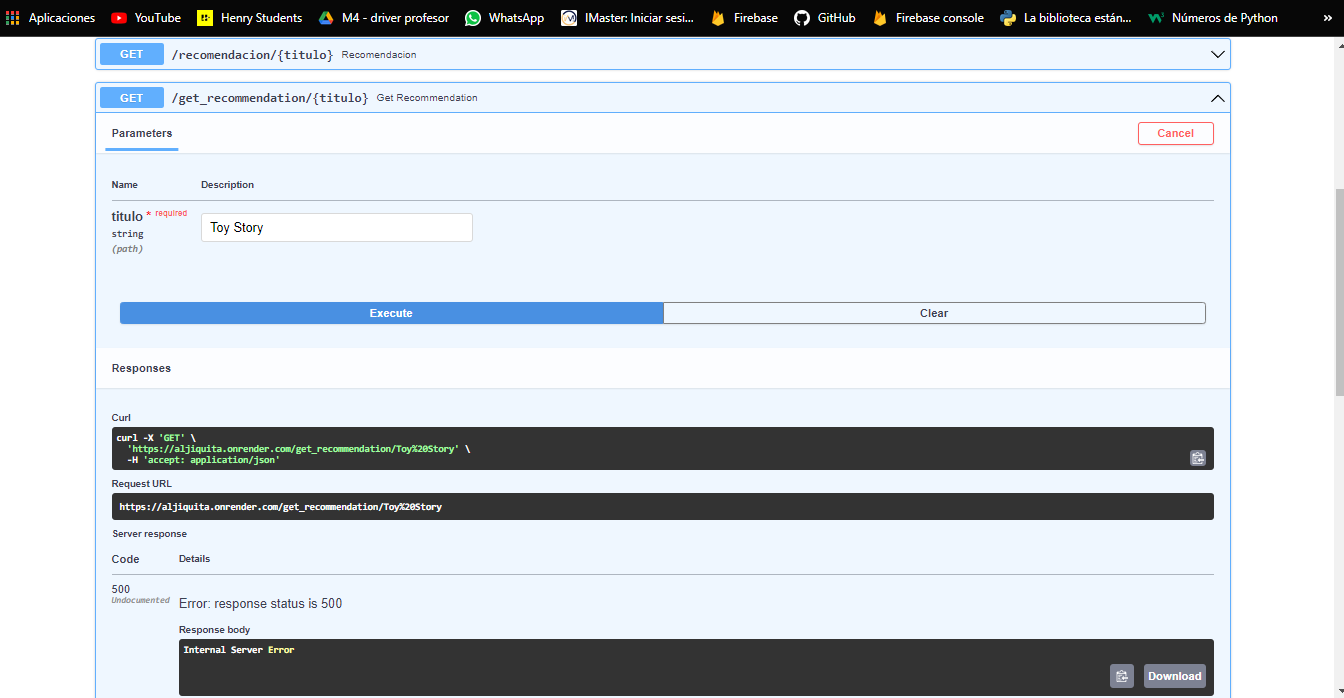

### Creamos un nuevo get_recommendation sin lematizar

In [78]:
df_get_reco = pd.read_csv("./DataSet/movies_dataset_Para_EDA.csv")
df_get_reco


,title,vote_average
0,Toy Story,7
1,Jumanji,6
2,Grumpier Old Men,6
3,Waiting to Exhale,6
4,Father of the Bride Part II,5
...,...,...
42383,The Burkittsville 7,7
42384,Caged Heat 3000,3
42385,Robin Hood,5
42386,Century of Birthing,9


In [79]:
def listar_titulo_sin_lematizar(titulo: str):
    # Le vamos aplicando la Normalizacion y luega el Stemming al titulo
    palabra = titulo
    # Tokenizamos para separar las palabras del titular
    palabra= nltk.word_tokenize(palabra)
    # Eliminamos las palabras de menos de 3 letras
    palabra = [palabra for palabra in palabra if len(palabra)>2]
    return palabra

print (listar_titulo_sin_lematizar("Toy Story"))

['Toy', 'Story']


In [80]:
def get_recommendation(titulo: str):
    palabra = listar_titulo_sin_lematizar(titulo)
    plReco = df_get_reco[["title", "vote_average"]][df_get_reco['title'].str.contains('|'.join(palabra))].sort_values("vote_average", ascending= False)
    lis_peli = list(plReco["title"].head(5)) 
    
    return lis_peli
    
#get_recommendation("Toy Story")
get_recommendation("Father of the Bride Part II")

['The Mother Of Invention',
 'A Story of the Forest: Mavka',
 'People of a Feather',
 'Southern Baptist Sissies',
 'Symphony of the Soil']